#  Libraries

In [1]:
import os, csv, re, glob, math, collections, sys, codecs
import xml.etree.ElementTree as ET
import pandas as pd
from matplotlib import pylab as plt
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
from numpy import *
from scipy import signal
from scipy.signal import find_peaks
from scipy import stats
from io import BytesIO
from colorama import *

# Profile gathering

## Experion files import - XML + CSV

In [2]:
full_xml_path = os.path.abspath(os.path.join(".", "CHIP5.xml"))
full_csv_path = os.path.abspath(os.path.join(".", "output.csv"))


tree = ET.parse(full_xml_path)
root = tree.getroot()

file_header = ['Sample']
file_header_vals = []
sample_well_info = []

*   Set File Header

In [3]:
for i in range(475, 869):
    file_header.append(str(round((0.00042006 * (i * i) - 0.28216 * i + 49.225), 1)))
    file_header_vals.append(str(round((0.00042006 * (i * i) - 0.28216 * i + 49.225), 1)))

*   get all well id's and sample names from file

In [4]:
for sample in root.findall('Results'):
    # write sample name
    well_id = sample.find('WellId').text

    if well_id != '0':
        sample_name = sample.find('SampleName').text
        sample_well_info.append({'Sample': sample_name, 'well_id': well_id})

*   create file with headers and data

In [5]:
with open(full_csv_path, 'w', newline='') as outcsv:
    writer = csv.DictWriter(outcsv, fieldnames = file_header)
    writer.writeheader()
    xmlstr = ET.tostring(root, encoding='utf8', method='xml').decode("utf-8")

    for elem in sample_well_info:
        
        idx = 0
        row = {'Sample': elem['Sample']}
        regex = '<RawDataPoints><WellId>%s<\/WellId><Signal>(.*?)<\/Signal><\/RawDataPoints>'% elem['well_id']
        raw_data_points = re.findall(regex, xmlstr)
        
        # write data for each column
        for count, raw_data_point in enumerate(raw_data_points, start=0):
            if 869 >= count >= 476:
                row[file_header_vals[idx]] = raw_data_point
                idx+=1
            
            if count > 869:
                break
        
        writer.writerow(row)

## Plot profiles

* transforming data to seaborn plot table

In [6]:
file1 = open('output.csv', 'r')
Lines = file1.readlines()

outfile = open('profile_plot.csv', 'w')
outfile.write('Sample,Molecular Weight,Fluorescence,\n')

header = Lines[0].strip().split(',')
mws = header[1:]

for line in Lines[1:]:
    line_info = line.strip().split(',')

    id = line_info[0]
    fl = line_info[1:]

    ix = 0
    for mw in mws:
        outfile.write(id + ','+ mws[ix]+','+fl[ix] +'\n')
        ix += 1

outfile.close()

* seaborn line plot

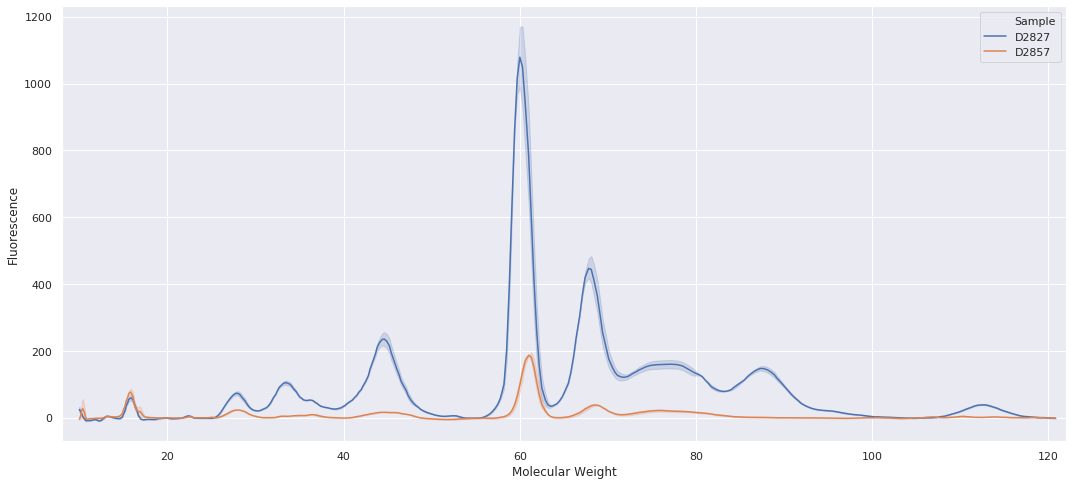

In [8]:
sb_plot = pd.read_csv("profile_plot.csv", header=0) #Dataset for ploting profiles using seaborn
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(18, 8))

profile_plot = sns.lineplot(x="Molecular Weight", y="Fluorescence",
             hue="Sample", data=sb_plot);

profile_plot.set(xlim=(8, 122));

In [21]:
df1 = pd.read_csv('chip1_2.csv')
df2 = pd.read_csv('chip3.csv')
df3 = pd.read_csv('chip4.csv')
df4 = pd.read_csv('chip5.csv')                  

finaldf = pd.concat([df1, df2, df3,df4], axis=0, join='inner')
finaldf.to_csv('finaldf.csv')